---

Desafio IoT - Detecção de Falhas em Componentes Eletromecânicos

Antonio Carlos da Anunciação - antoniocarlos2708@gmail.com

---

In [2]:
from influxdb import DataFrameClient as db_con

from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

from scipy.interpolate import interpn
from scipy.stats import gaussian_kde

from matplotlib.colors import Normalize 
import matplotlib.pyplot as plt
from matplotlib import cm

import pandas as pd
import numpy as np

import os

In [3]:
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        if feature_name != 'time_stamp':
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [4]:
def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [5]:
def plot_moving_average(component, series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Media Movel - ' + component + '\n window size = {}'.format(window) + 'segundos')
    plt.plot(series[window:], label='Serie Original')
    plt.plot(rolling_mean, 'r', label='Media Movel')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Limite Inferior / Limite Superior')
        plt.plot(lower_bound, 'r--')
            
    plt.legend(loc='best')
    plt.grid(True)

In [6]:
def Valores_Medios(X, periodo = 'minuto'):
    
    if periodo == 'hora':
        periodo = 3600
    if periodo == 'dia':
        periodo = 24*3600
    if periodo == 'minuto':
        periodo = 60
    
    j, vel, temp = 0, 0, 0
    vel_min, temp_min = [], []
    for i in range(X.shape[0]):
        j += 1
        vel = vel + X[i, 1]
        temp = temp + X[i, 2]

        if j == periodo or j == X.shape[0]-1:
            vel_min.append(vel/j)
            temp_min.append(temp/j)
            j, vel, temp = 0, 0, 0
    return vel_min, temp_min

In [7]:
def Plot(velList, tempList, periodo):
    plt.figure(figsize=(20,30))
    i = 1
    for vel, temp in zip(velList, tempList):
        plt.subplot(8,2,2*i-1)
        plt.plot(vel, label = "Vel_rms", color="blue")
        plt.legend(loc="best")
        plt.subplot(8,2,2*i)
        plt.plot(temp, label = "Temperatura", color="green")
        plt.legend(loc="best")
        i += 1
    #plt.suptitle("Amostragem medida em " + periodo, fontsize=16)
    plt.show()

---
Carregando os dados:

In [8]:
dataframes = []
try:
    print("Carregando dados locais...")
    for file in os.listdir():
        if file.split('.')[-1] == 'csv':
            dataframes.append(pd.read_csv(file))
    print("Dados carregados da maquina local.")
except:
    print("FALHA!\nCarregando dados remotos...\n")
    
    db = db_con(host='34.122.223.6',
            port=8086,
            username='challenge',
            password='chall3ng3',
            database='industrial_equipment',
            retries = 1)
    
    querys = []
    querys.append("""SELECT "object_temp","vel_rms_e" FROM "serialized" where "component"='1' """)
    querys.append("""SELECT "object_temp","vel_rms_e" FROM "serialized" where "component"='2' """)
    querys.append("""SELECT "object_temp","vel_rms_e" FROM "serialized" where "component"='3' """)
    querys.append("""SELECT "object_temp","vel_rms_e" FROM "serialized" where "component"='4' """)
    querys.append("""SELECT "object_temp","vel_rms_e" FROM "serialized" where "component"='5' """)
    querys.append("""SELECT "object_temp","vel_rms_e" FROM "serialized" where "component"='6' """)
    querys.append("""SELECT "object_temp","vel_rms_e" FROM "serialized" where "component"='7' """)
    querys.append("""SELECT "object_temp","vel_rms_e" FROM "serialized" where "component"='8' """)
    
    for query in querys:
        data = db.query(query)
        dataframes.append(data['serialized'].reset_index())
        
    for i in range(len(dataframes)):
        dataframes[i] = dataframes[i].rename(columns = {'index':'time_stamp'})
        
    print("Dados carregados remotamente e formatados.")

Carregando dados locais...
Dados carregados da maquina local.


---
Salvando arquivos remotos:

In [ ]:
index = 1
for dataframe in dataframes:
    component = str(index)
    file_name = 'component_' + component + '.csv'
    dataframe.to_csv(file_name)
    index += 1

---
Plot:

In [9]:
pd.options.display.float_format = '{:,.2f}'.format

In [10]:
descricao = []
for i in range(8):
    descricao.append(dataframes[i][["object_temp","vel_rms_e"]].describe())

In [11]:
for desc in descricao:
    print(desc)

       object_temp  vel_rms_e
count 4,634,755.00 702,716.00
mean         45.36       0.48
std           7.45       0.19
min          25.01       0.00
25%          42.88       0.50
50%          47.09       0.54
75%          50.05       0.58
max          61.84       2.70
       object_temp  vel_rms_e
count   458,550.00 176,653.00
mean         70.33       1.58
std           8.80       0.53
min          25.79       0.00
25%          69.75       1.37
50%          71.98       1.46
75%          74.40       1.58
max          80.01       3.13
       object_temp  vel_rms_e
count 2,189,055.00 562,042.00
mean         54.30       0.86
std           7.67       0.95
min          32.09       0.00
25%          48.56       0.30
50%          53.89       0.45
75%          59.69       1.16
max          77.29       3.73
       object_temp    vel_rms_e
count 5,165,739.00 1,255,084.00
mean         51.71         2.46
std           2.73         0.13
min          43.64         0.00
25%          49.77         2.3

In [12]:
review = []
column_names = ["Total de Segundos", "Total de Minutos", "Total de Horas", "Todas de Dias"]
for dataframe in dataframes:
    review.append([dataframe.shape[0], dataframe.shape[0]/60, dataframe.shape[0]/60/60, dataframe.shape[0]/60/60/24])  
df_review = pd.DataFrame(review, columns = column_names)
del(review)

In [13]:
df_review.head(8)

Total de Segundos  Total de Minutos  Total de Horas  Todas de Dias
0            4690383         78,173.05        1,302.88          54.29
1             602221         10,037.02          167.28           6.97
2            2195540         36,592.33          609.87          25.41
3            5202430         86,707.17        1,445.12          60.21
4            1056406         17,606.77          293.45          12.23
5            4713375         78,556.25        1,309.27          54.55
6            1659041         27,650.68          460.84          19.20
7            4326273         72,104.55        1,201.74          50.07

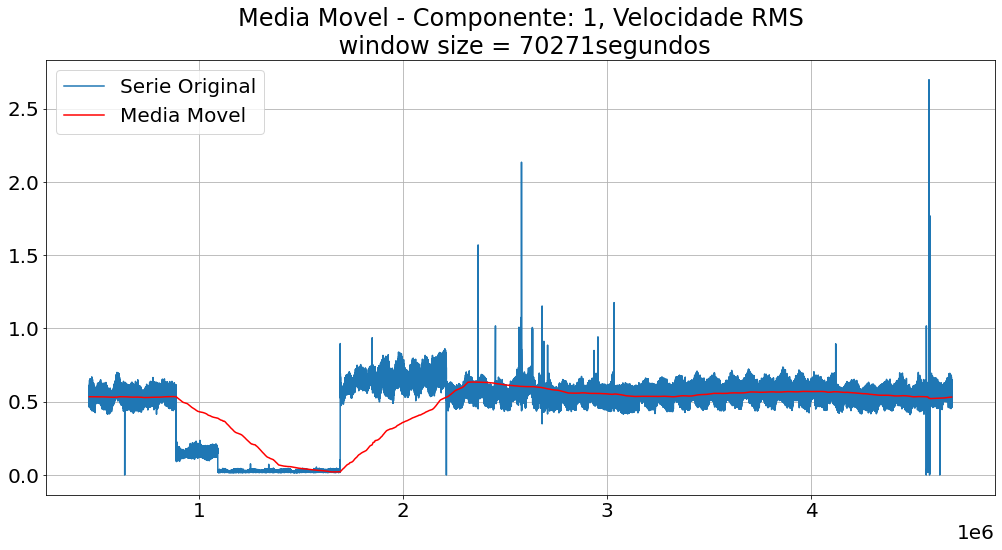

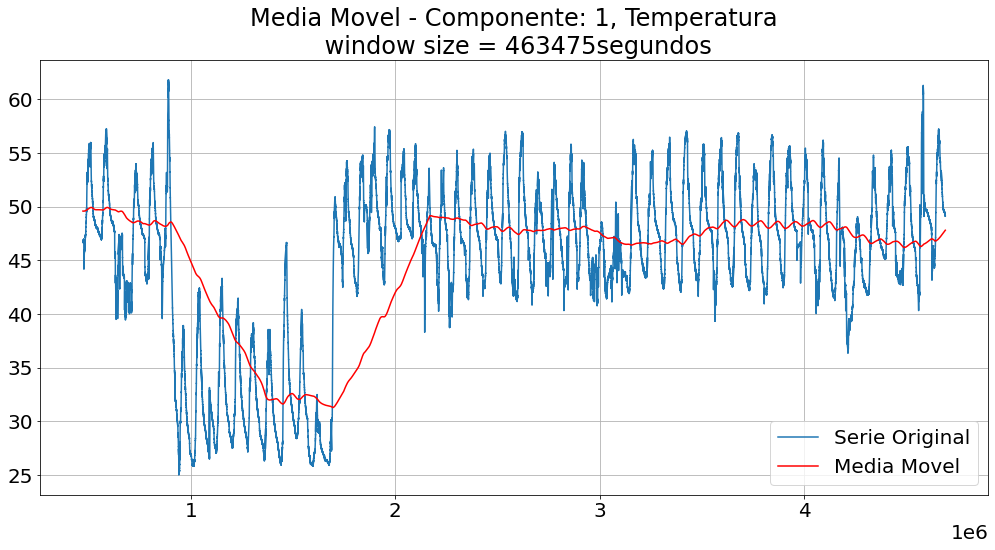

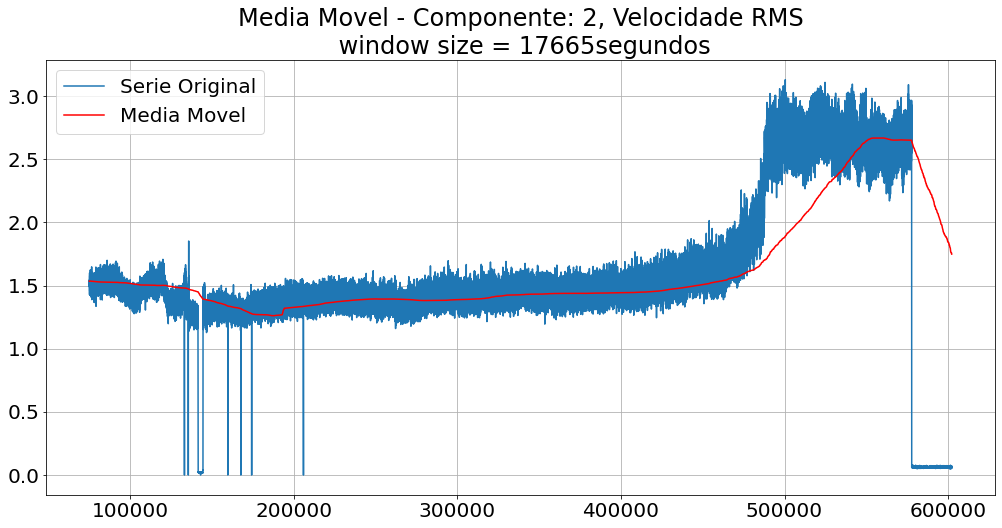

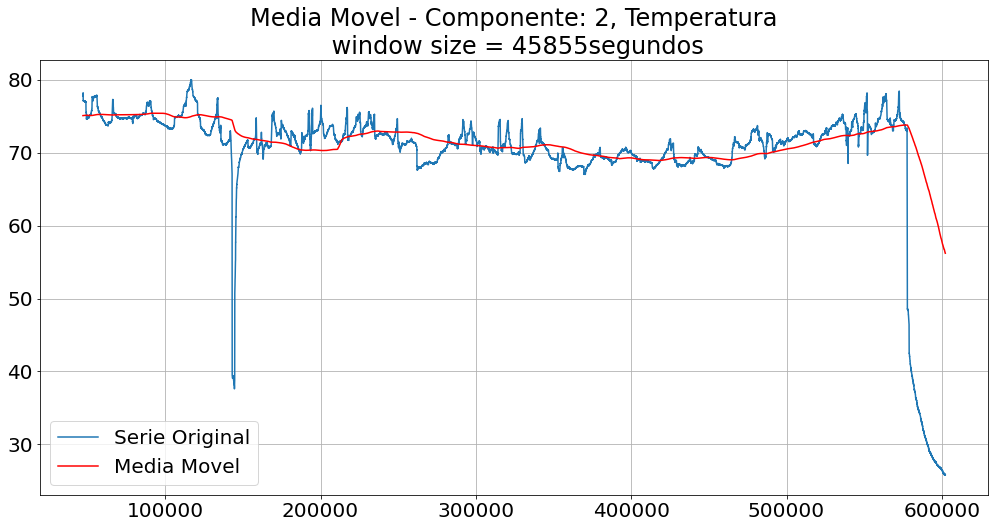

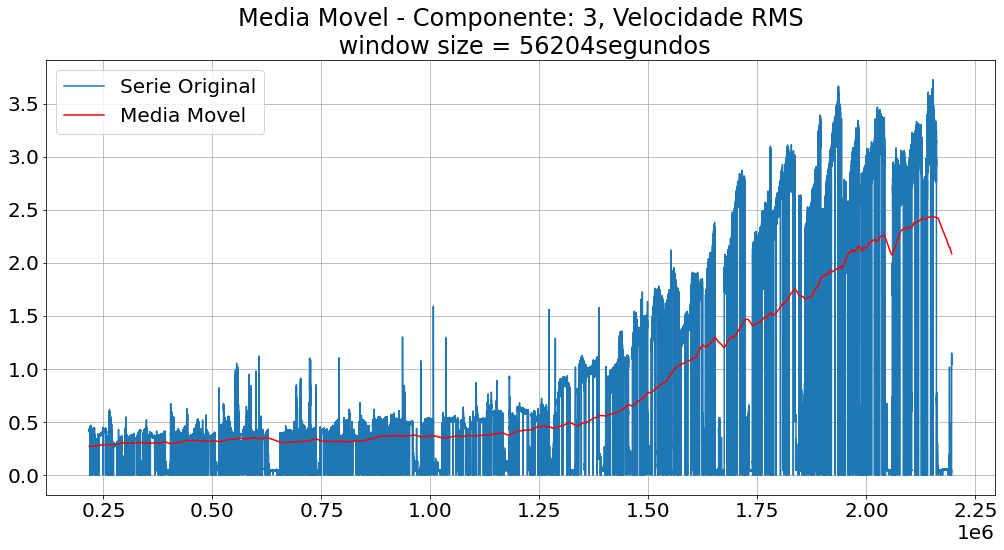

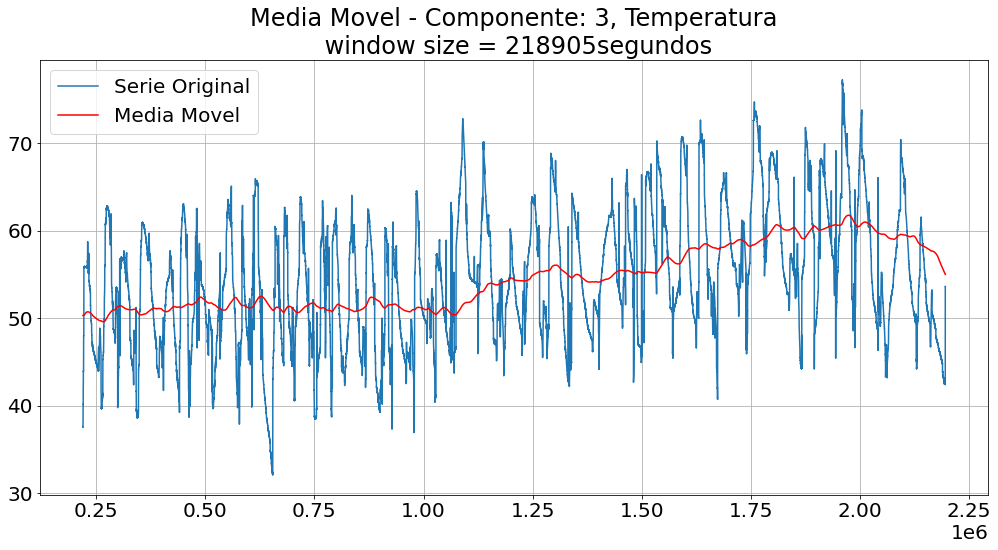

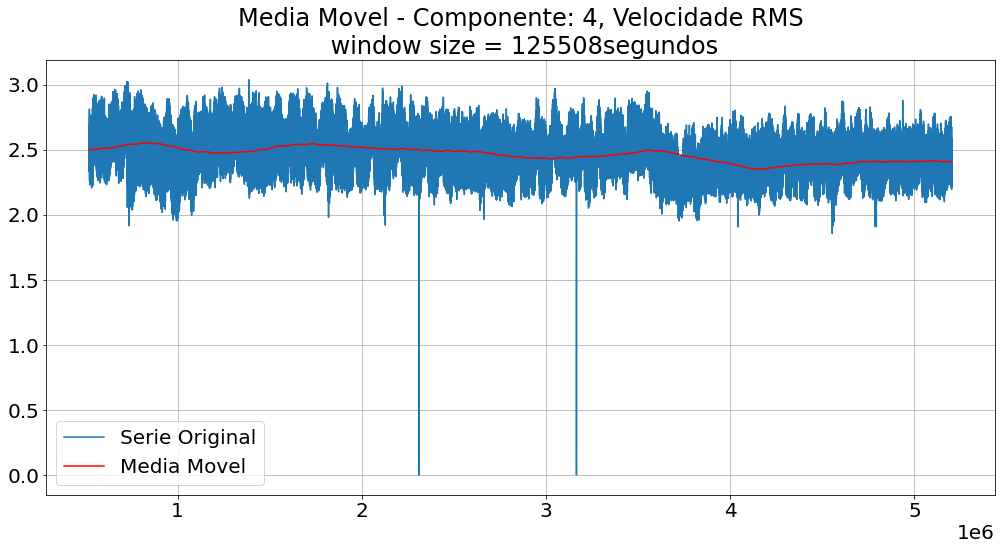

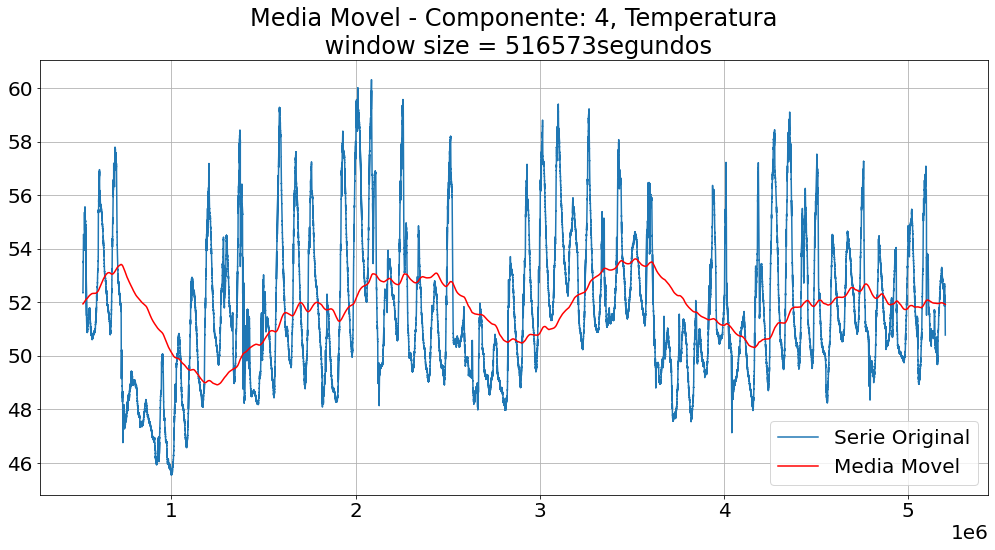

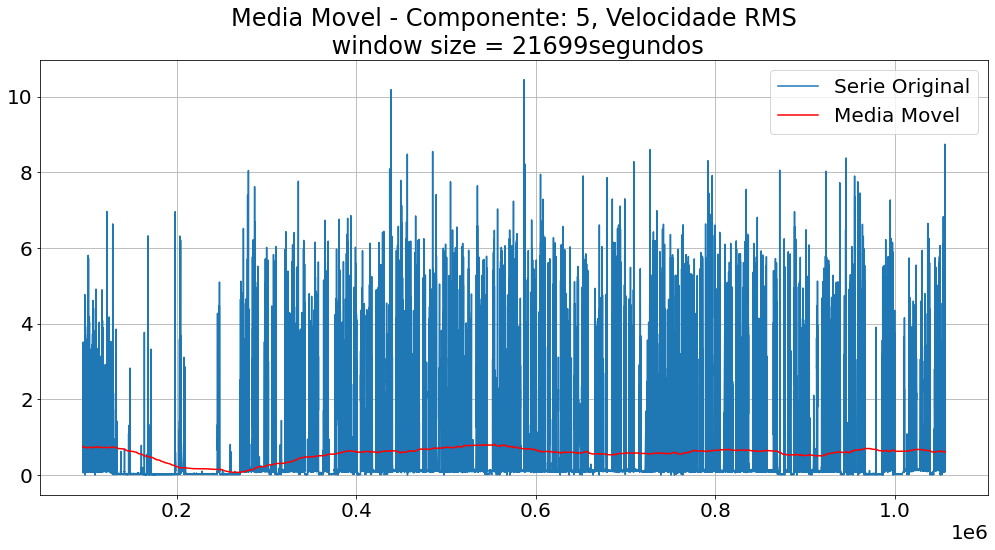

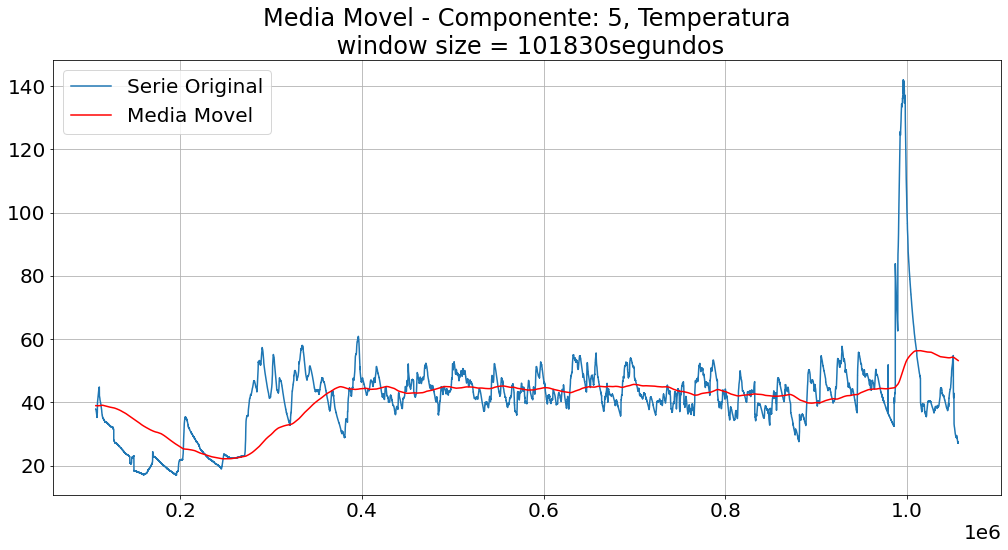

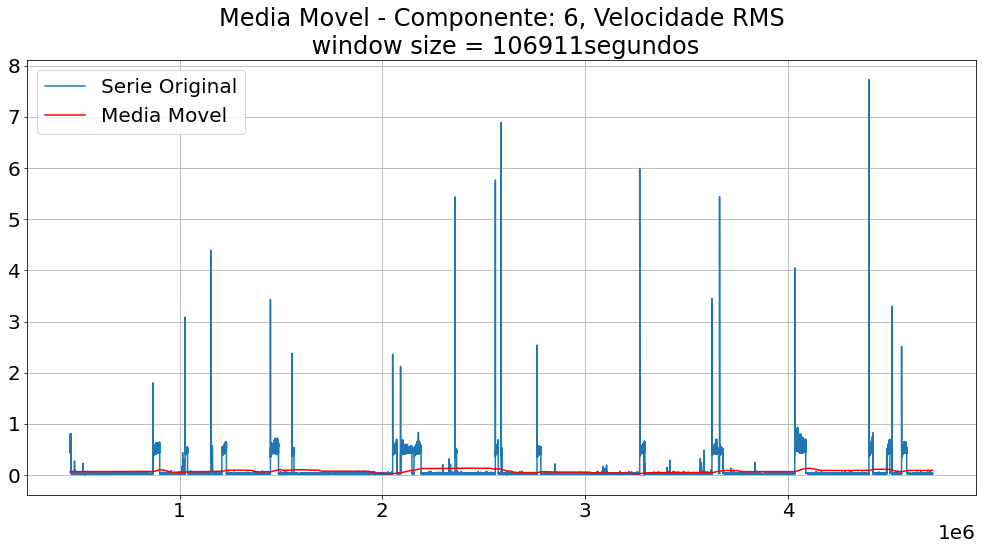

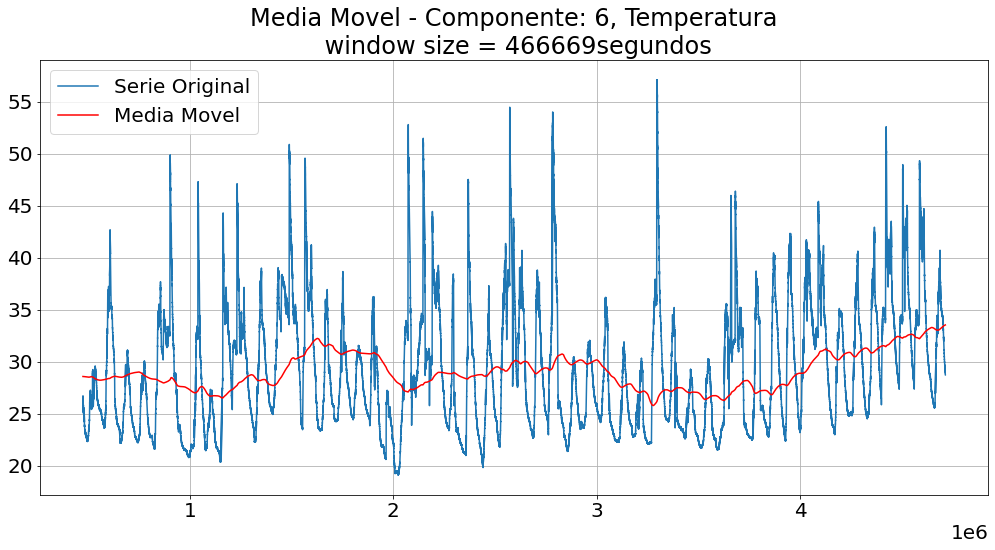

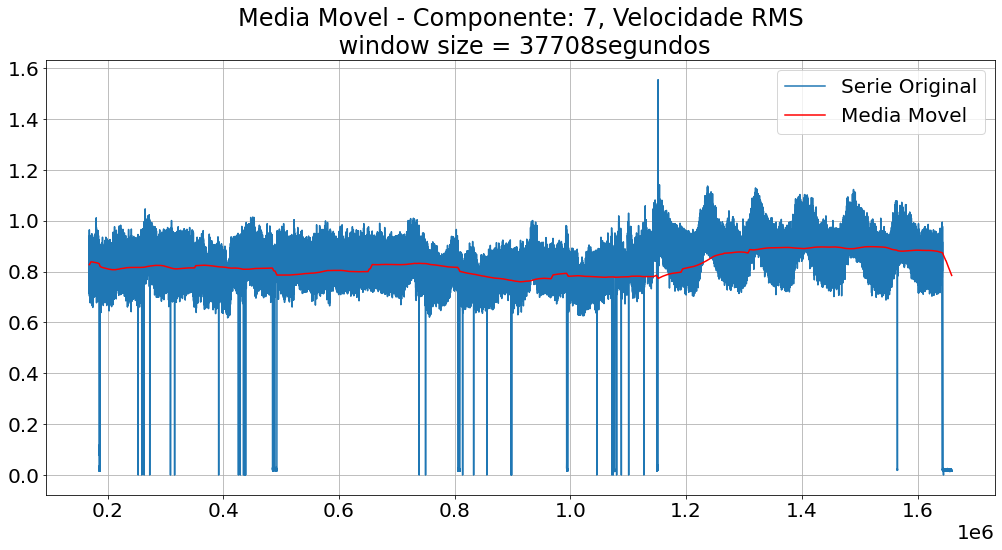

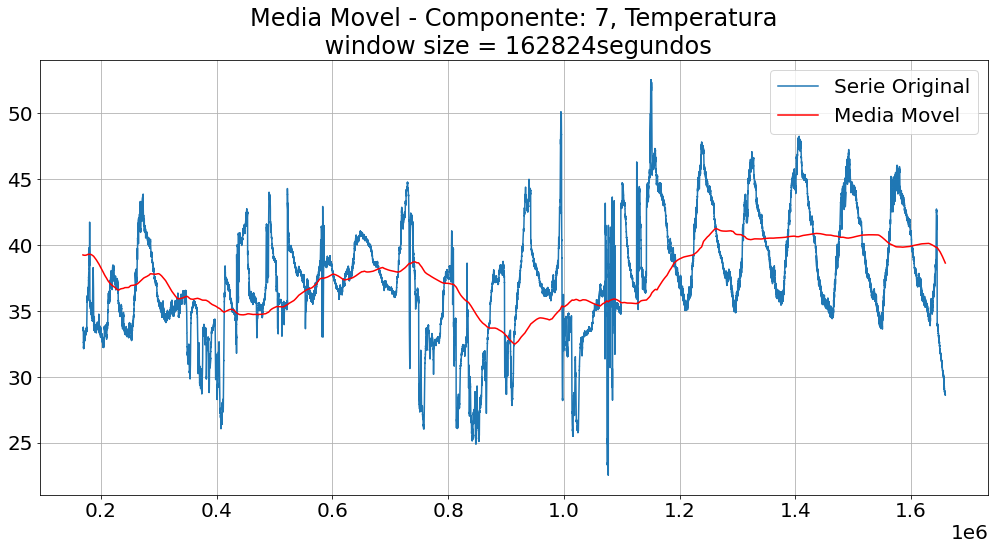

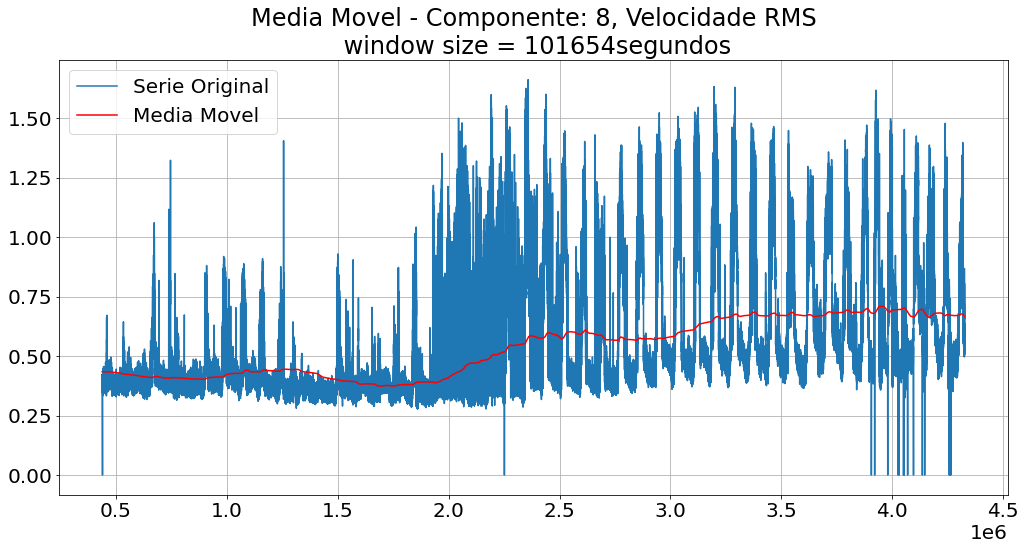

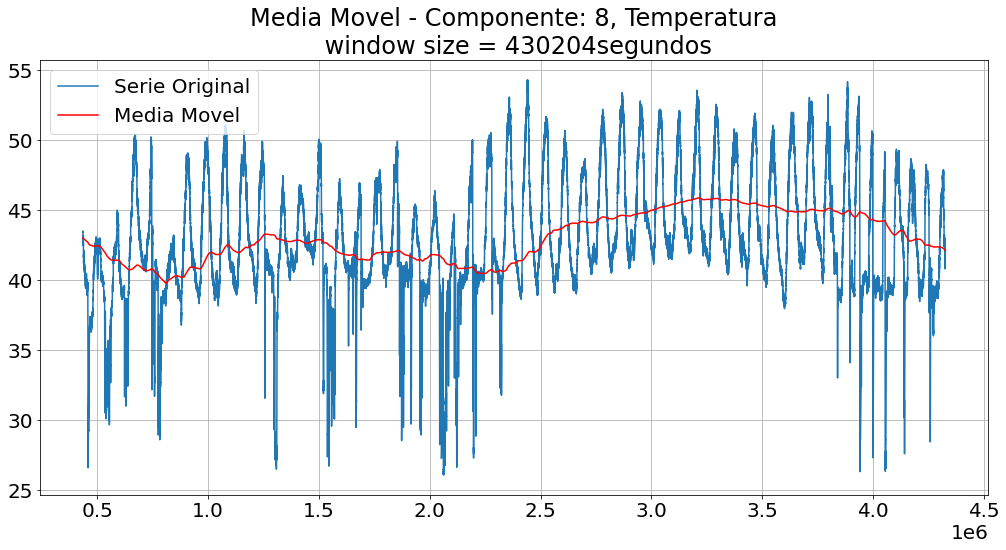

In [14]:
plt.rcParams.update({'font.size': 20})
medicao = ['Velocidade RMS', 'Temperatura']
for i in range(8):
    component, janela = [], []
    component.append((dataframes[i].vel_rms_e).dropna())
    component.append((dataframes[i].object_temp).dropna())
    for j in range(2):
        label = "Componente: " + str(i+1) + ", " + medicao[j]
        plot_moving_average(label, component[j], int(component[j].shape[0]/10))

Media movel horaria:


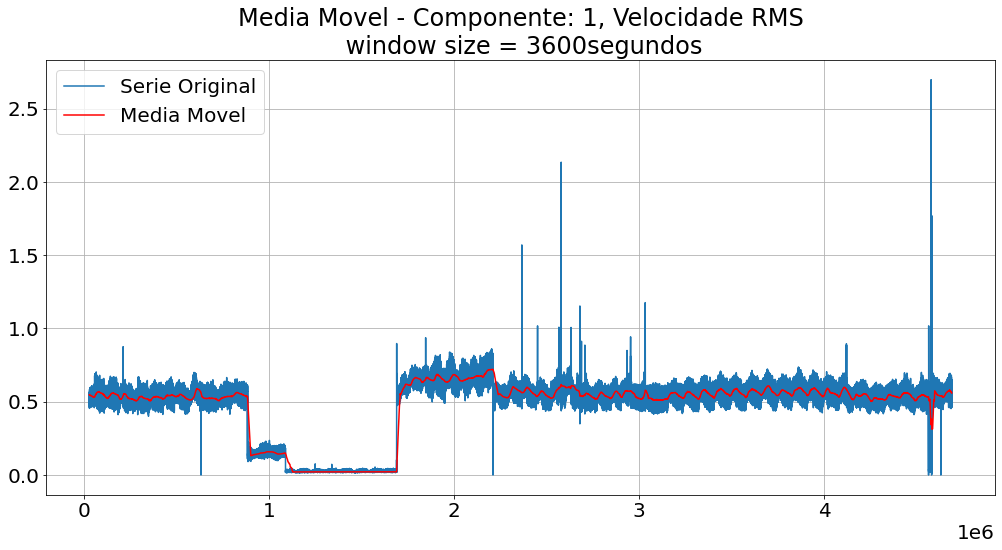

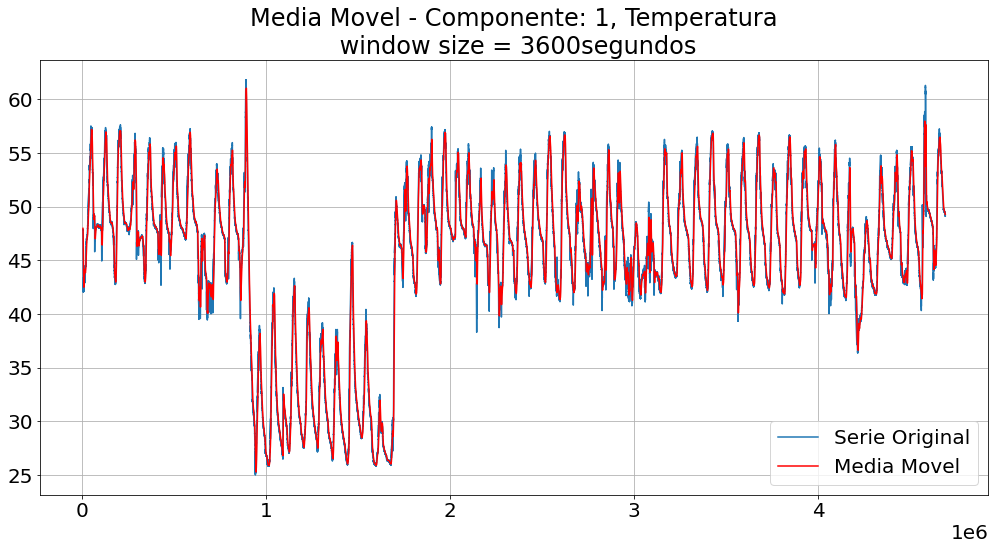

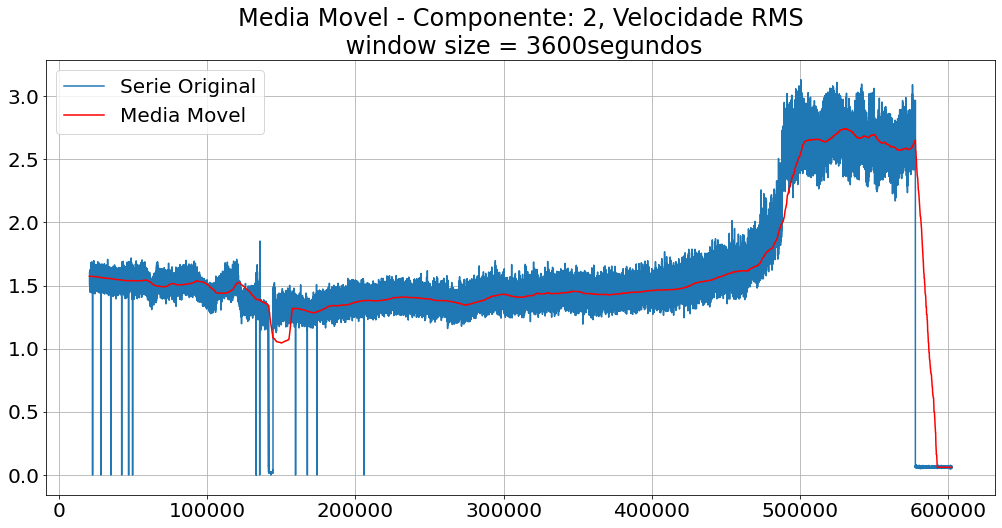

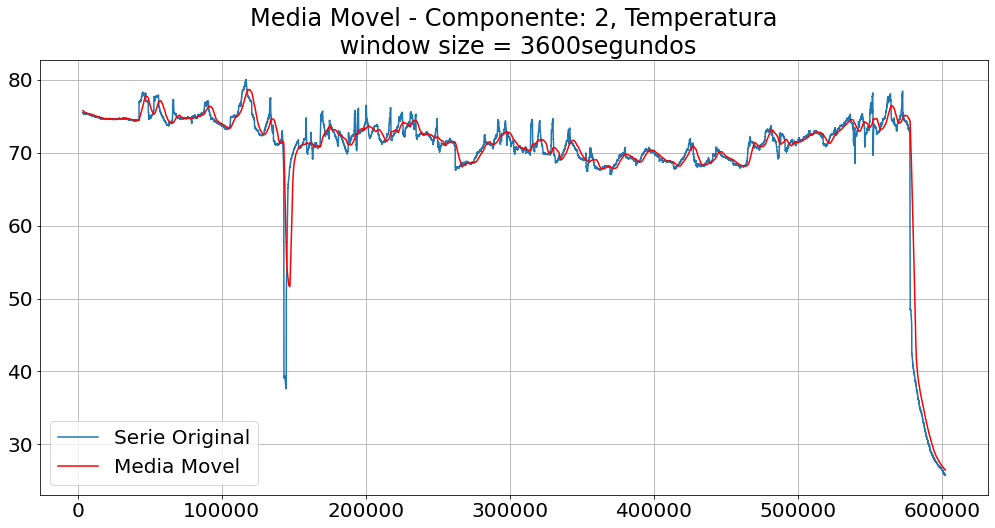

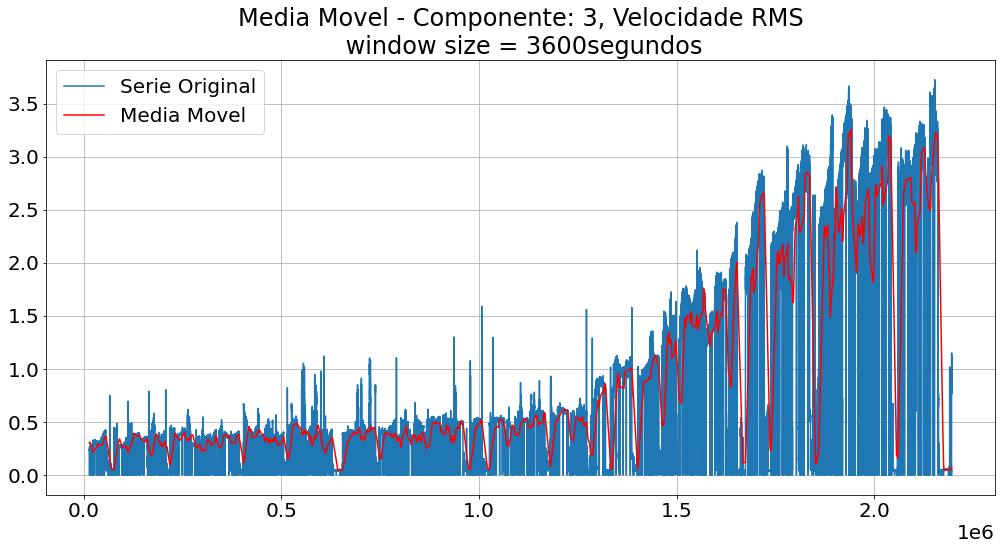

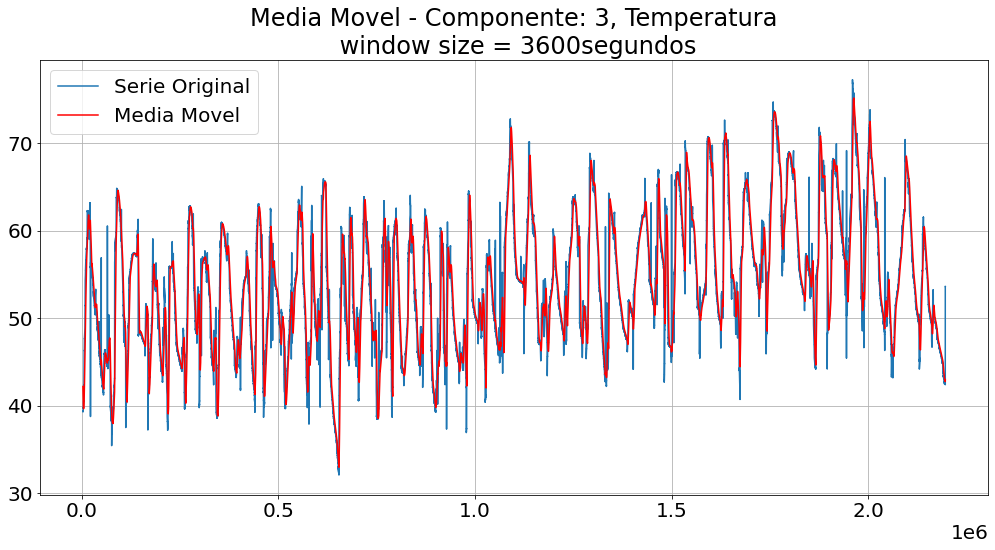

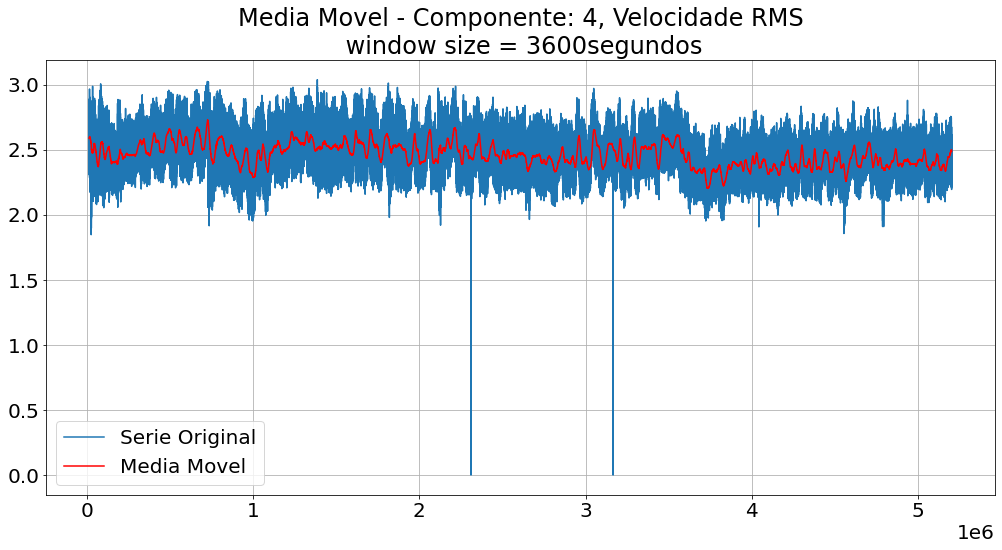

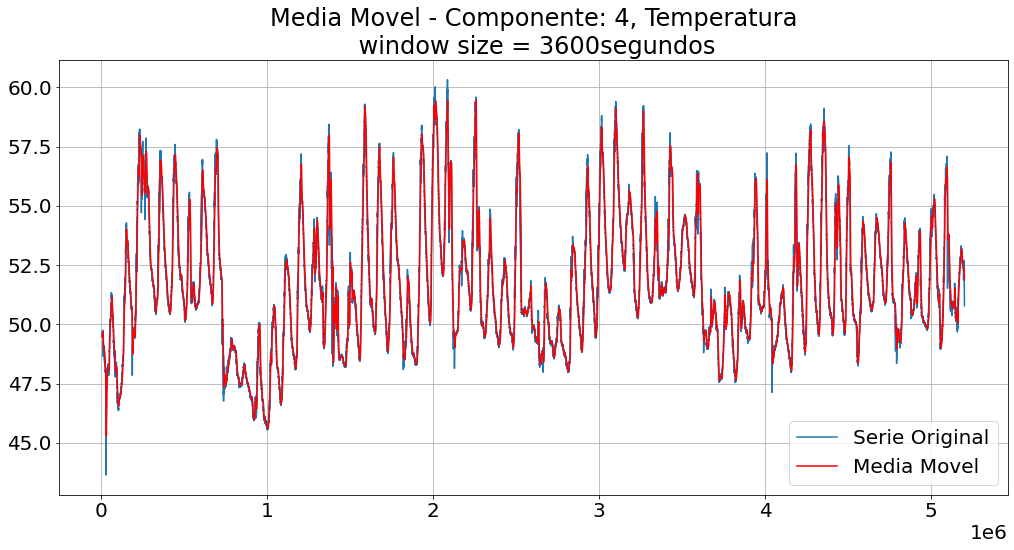

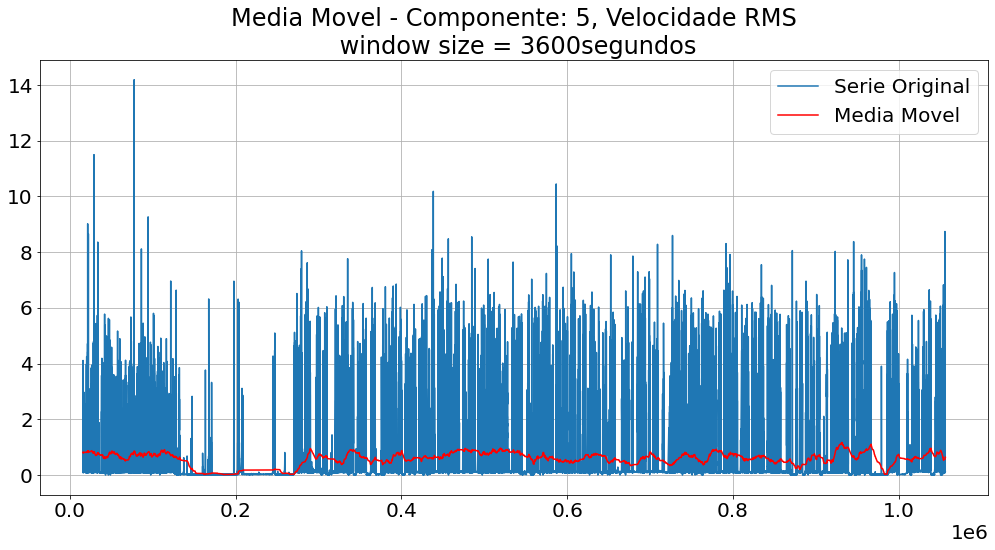

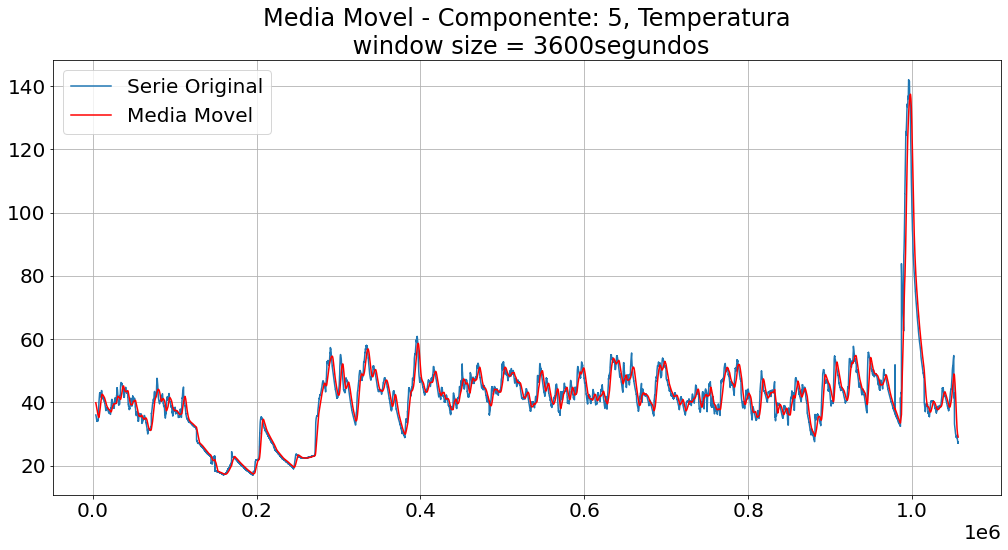

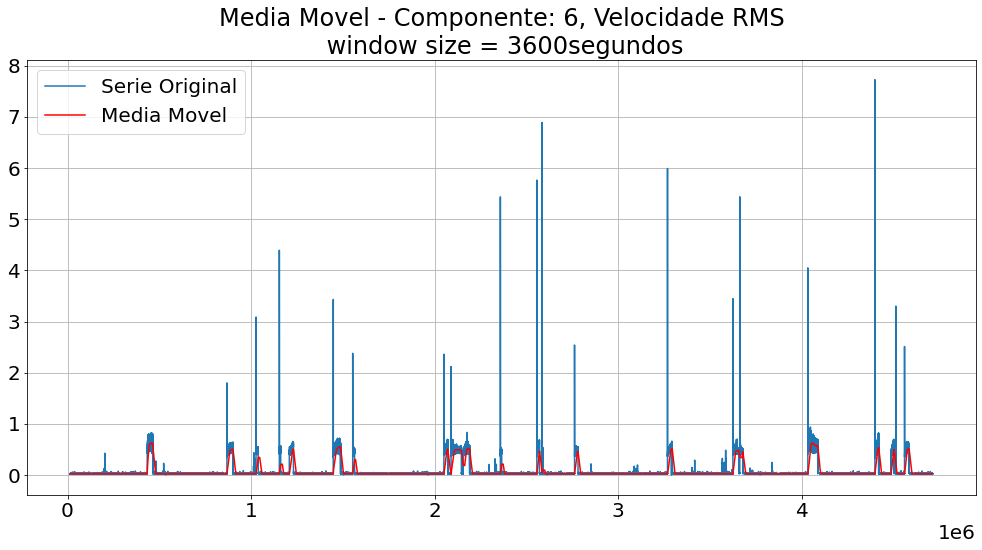

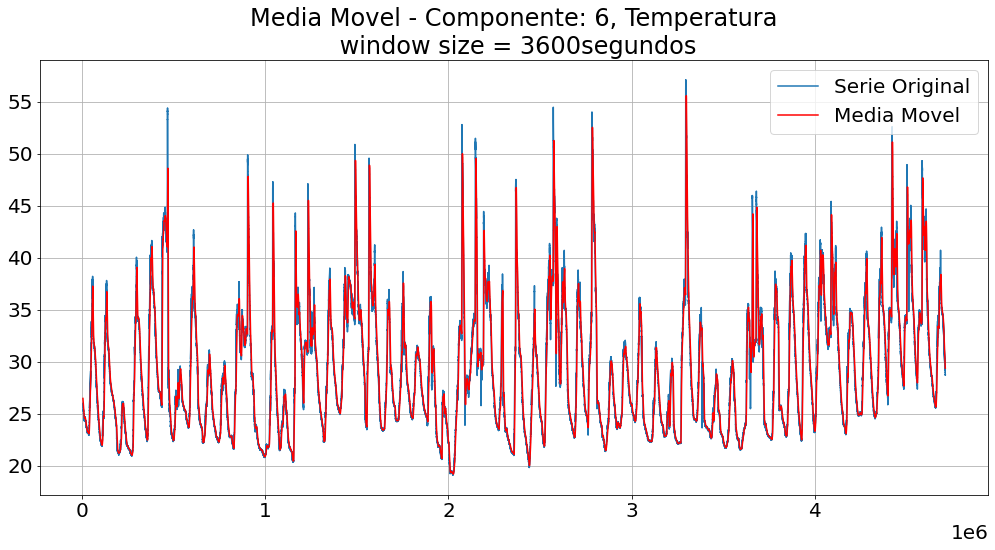

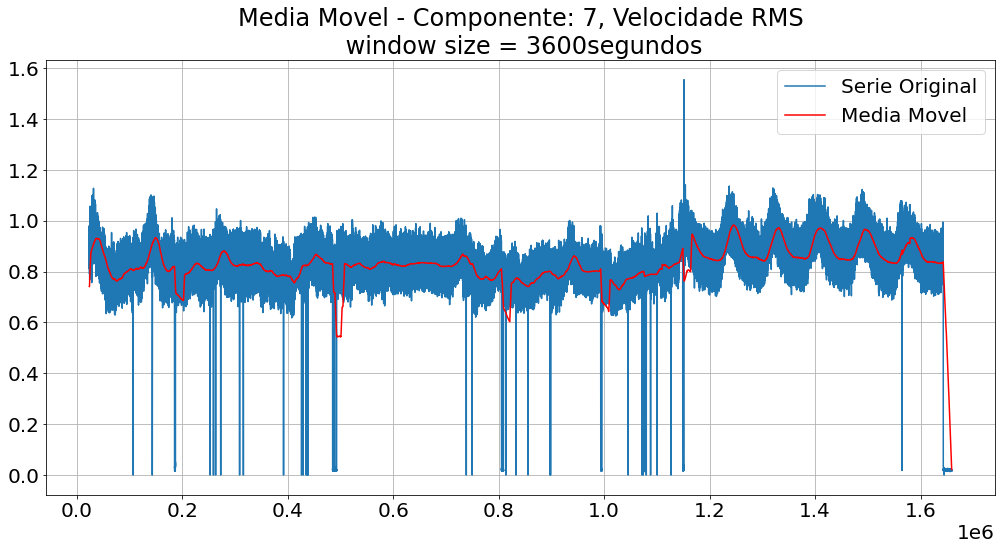

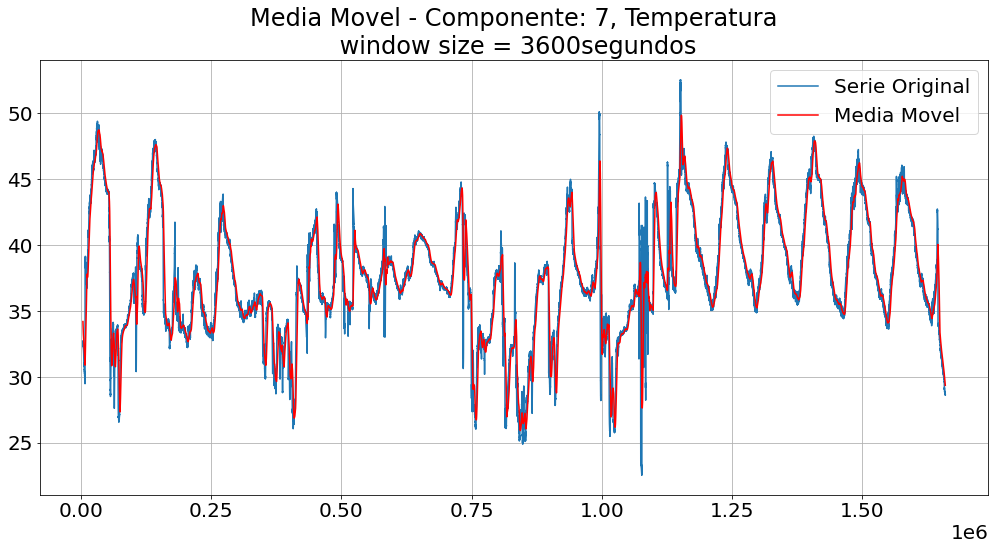

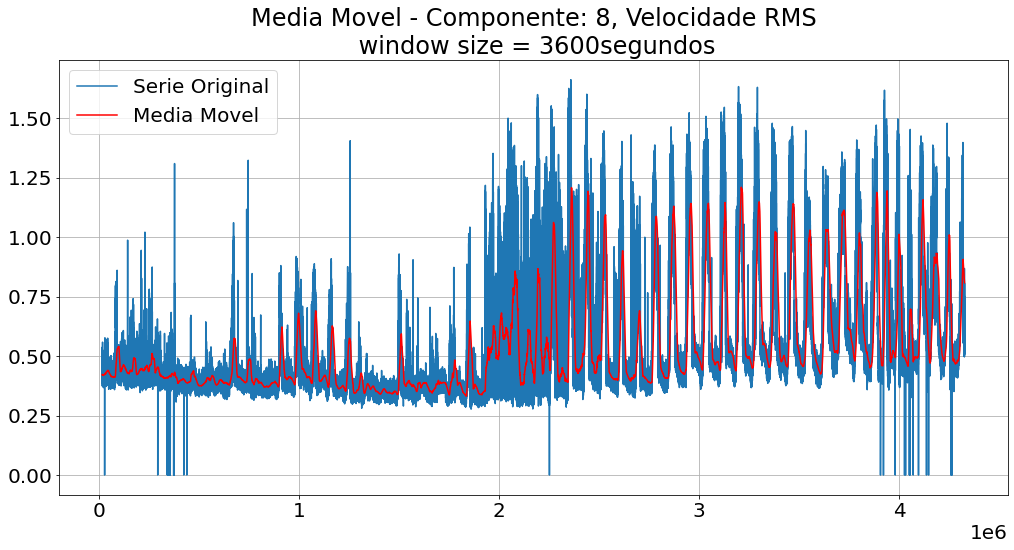

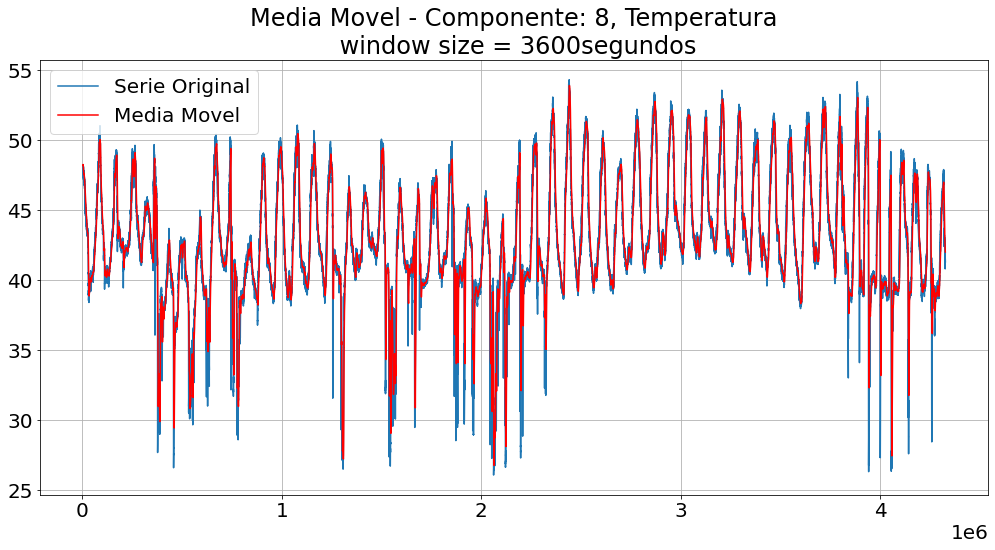

In [15]:
medicao = ['Velocidade RMS', 'Temperatura']
print("Media movel horaria:")
for i in range(8):
    component = []
    component.append((dataframes[i].vel_rms_e).dropna())
    component.append((dataframes[i].object_temp).dropna())
    for j in range(2):
        label = "Componente: " + str(i+1) + ", " + medicao[j]
        plot_moving_average(label, component[j], 3600)

Component 1


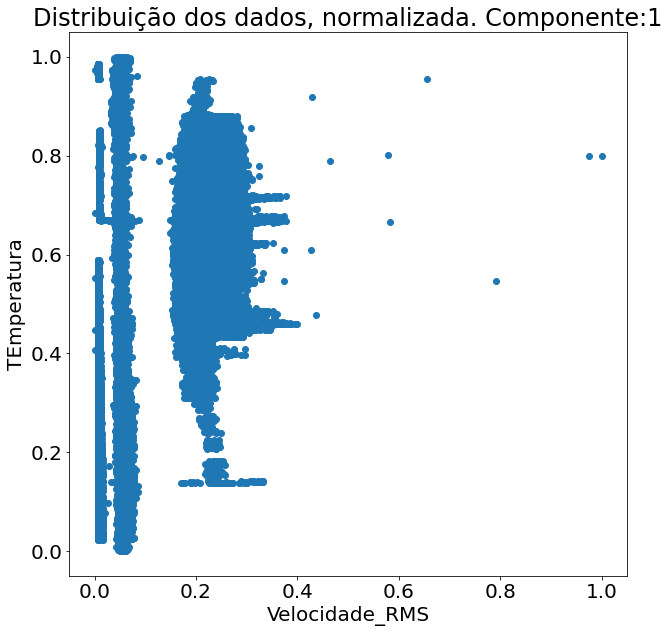

Component 2


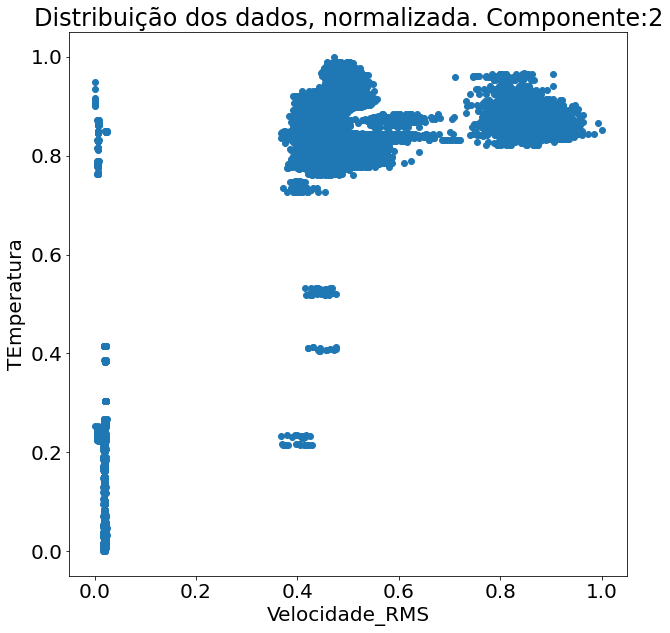

Component 3


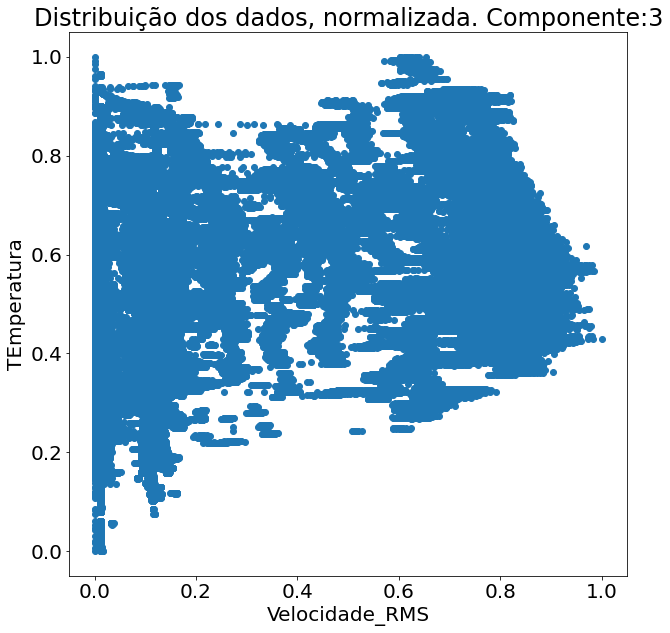

Component 4


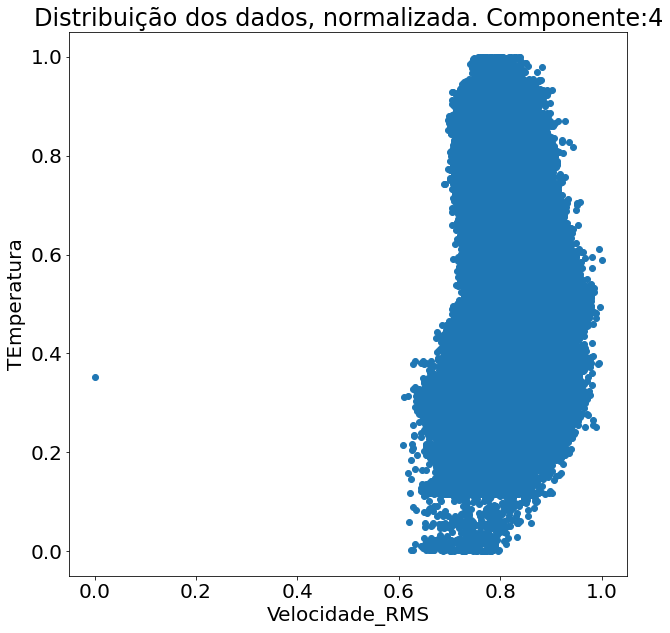

Component 5


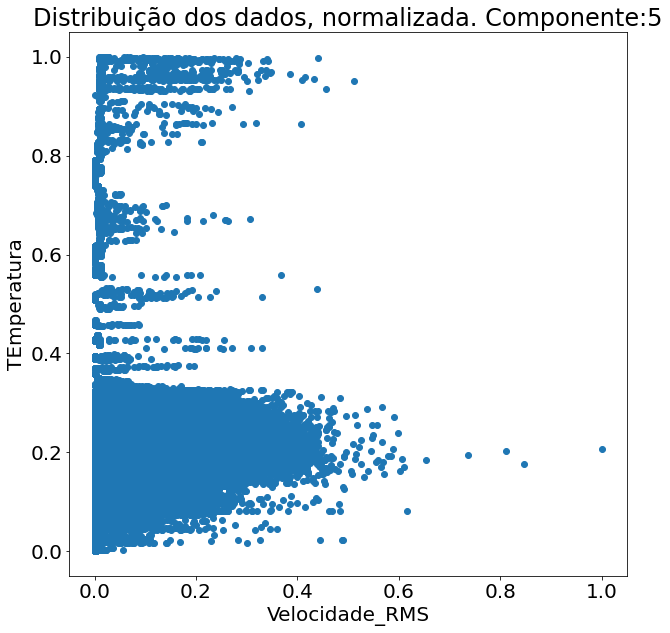

Component 6


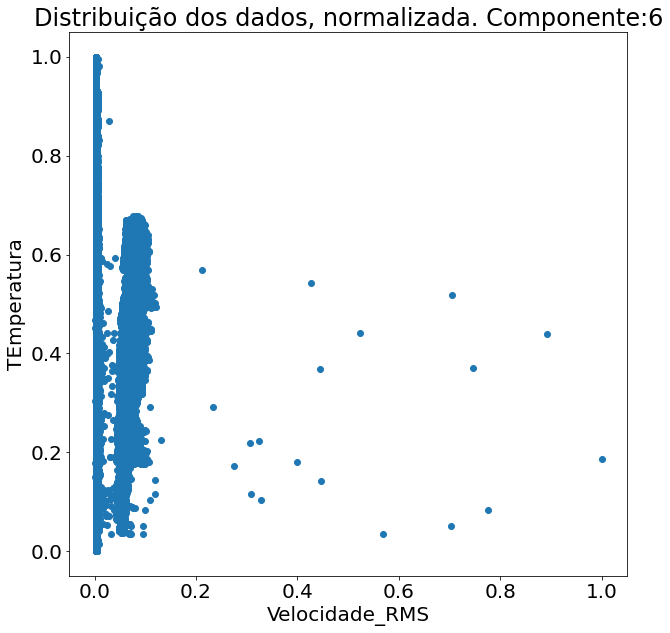

Component 7


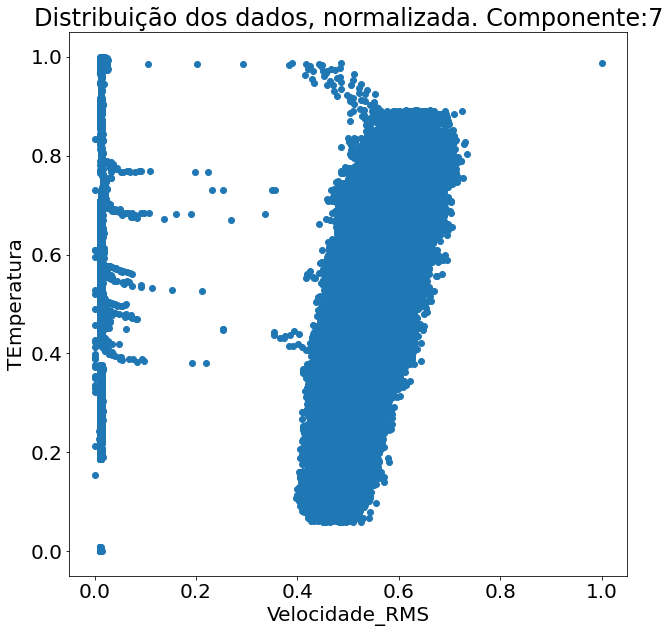

Component 8


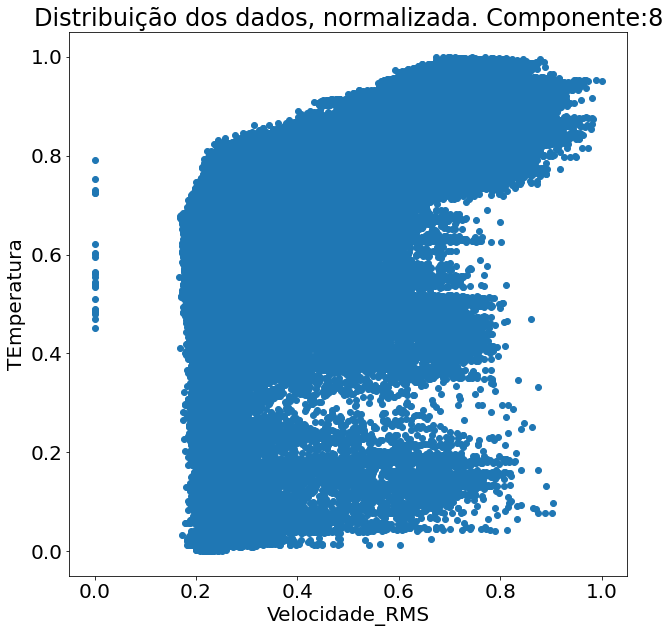

In [16]:
for i in range(8):
    scatter = dataframes[i].dropna()
    scatter_norm = normalize(scatter)
    print("Component " + str(i+1))
    plt.figure(figsize=(10,10))
    plt.scatter(scatter_norm.vel_rms_e, scatter_norm.object_temp)
    plt.title('Distribuição dos dados, normalizada. Componente:' + str(i+1))
    plt.xlabel("Velocidade_RMS")
    plt.ylabel("TEmperatura")
    plt.show()

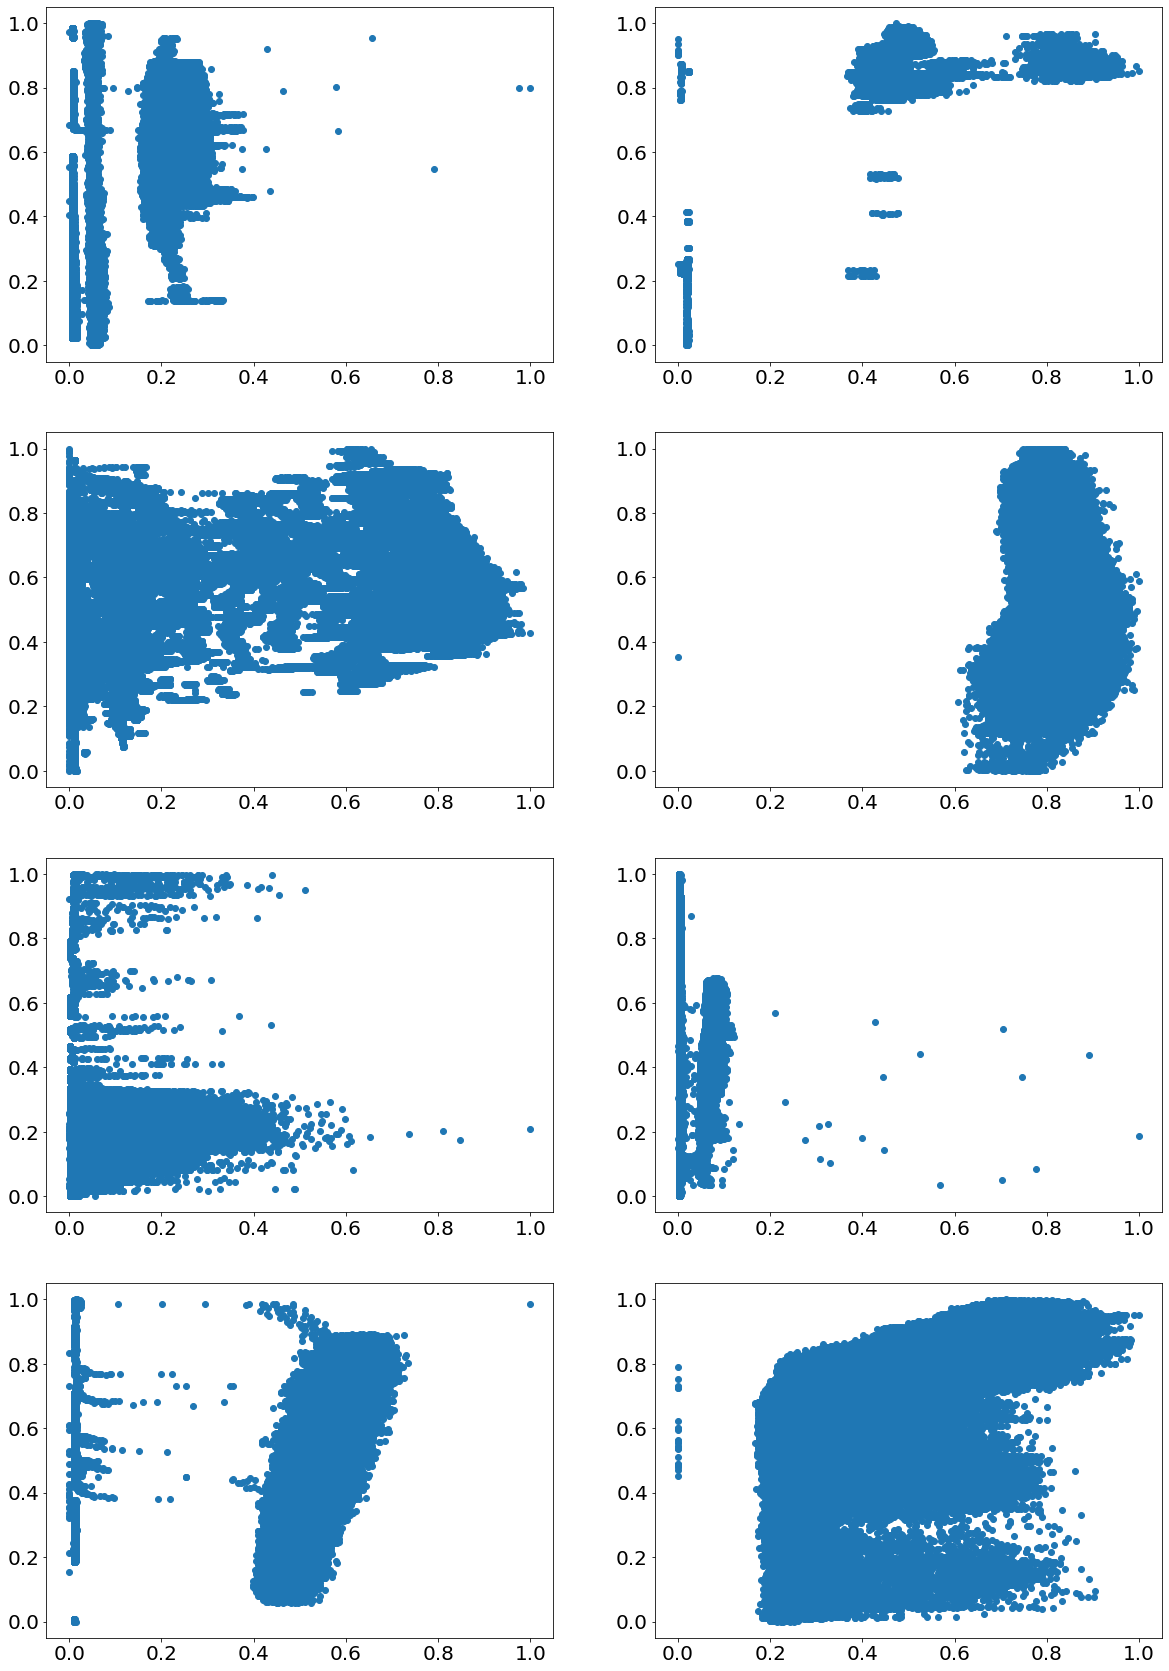

In [17]:
    plt.figure(figsize=(20,30))
    i = 1
    for i in range(8):
        plt.subplot(4,2,i+1)
        scatter = dataframes[i].dropna()
        scatter_norm = normalize(scatter)
        plt.scatter(scatter_norm.vel_rms_e, scatter_norm.object_temp)
    #plt.suptitle("Amostragem medida em " + periodo, fontsize=16)
    plt.show()

Component 3


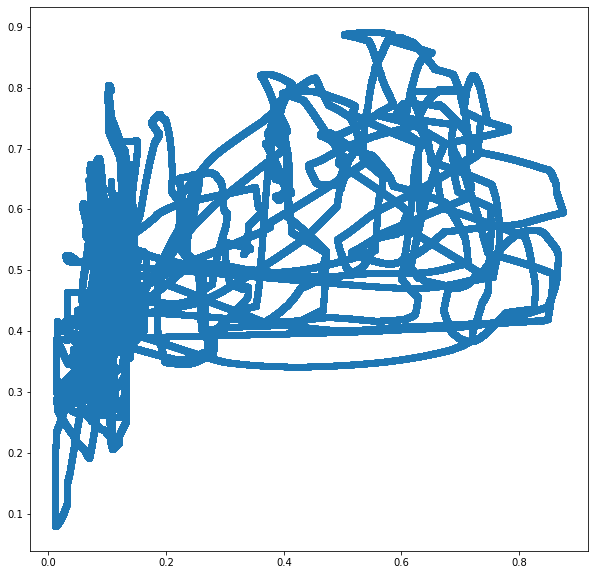

In [16]:
janela = 3600
print("Component " + str(3))
plt.figure(figsize=(10,10))
scatter = dataframes[2].dropna()
scatter_norm = normalize(scatter)
media_movel = scatter_norm.rolling(janela).mean()
plt.scatter(media_movel.vel_rms_e, media_movel.object_temp)
plt.show()

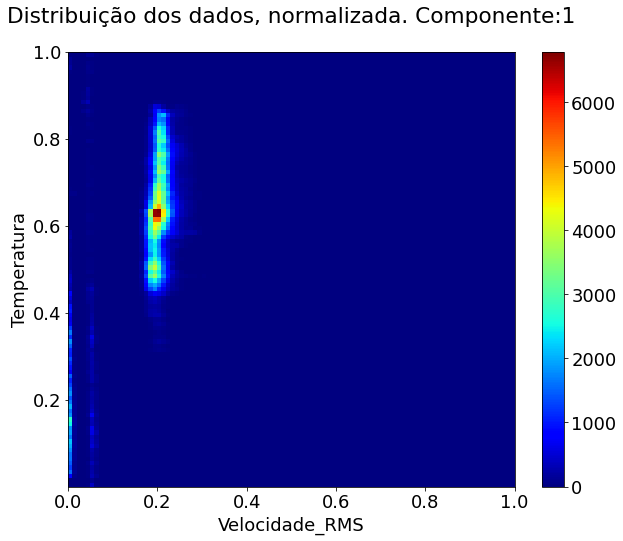

In [18]:
janela = 1
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(10,8))
scatter = dataframes[0]
scatter_norm = normalize(scatter)
media_movel = (scatter_norm.rolling(janela).mean()).dropna()
plt.hist2d(media_movel.vel_rms_e, media_movel.object_temp, (100, 100), cmap=plt.cm.jet)
plt.title('Distribuição dos dados, normalizada. Componente:' + str(1) + '\n')
plt.xlabel("Velocidade_RMS")
plt.ylabel("Temperatura")
plt.colorbar()
plt.show()

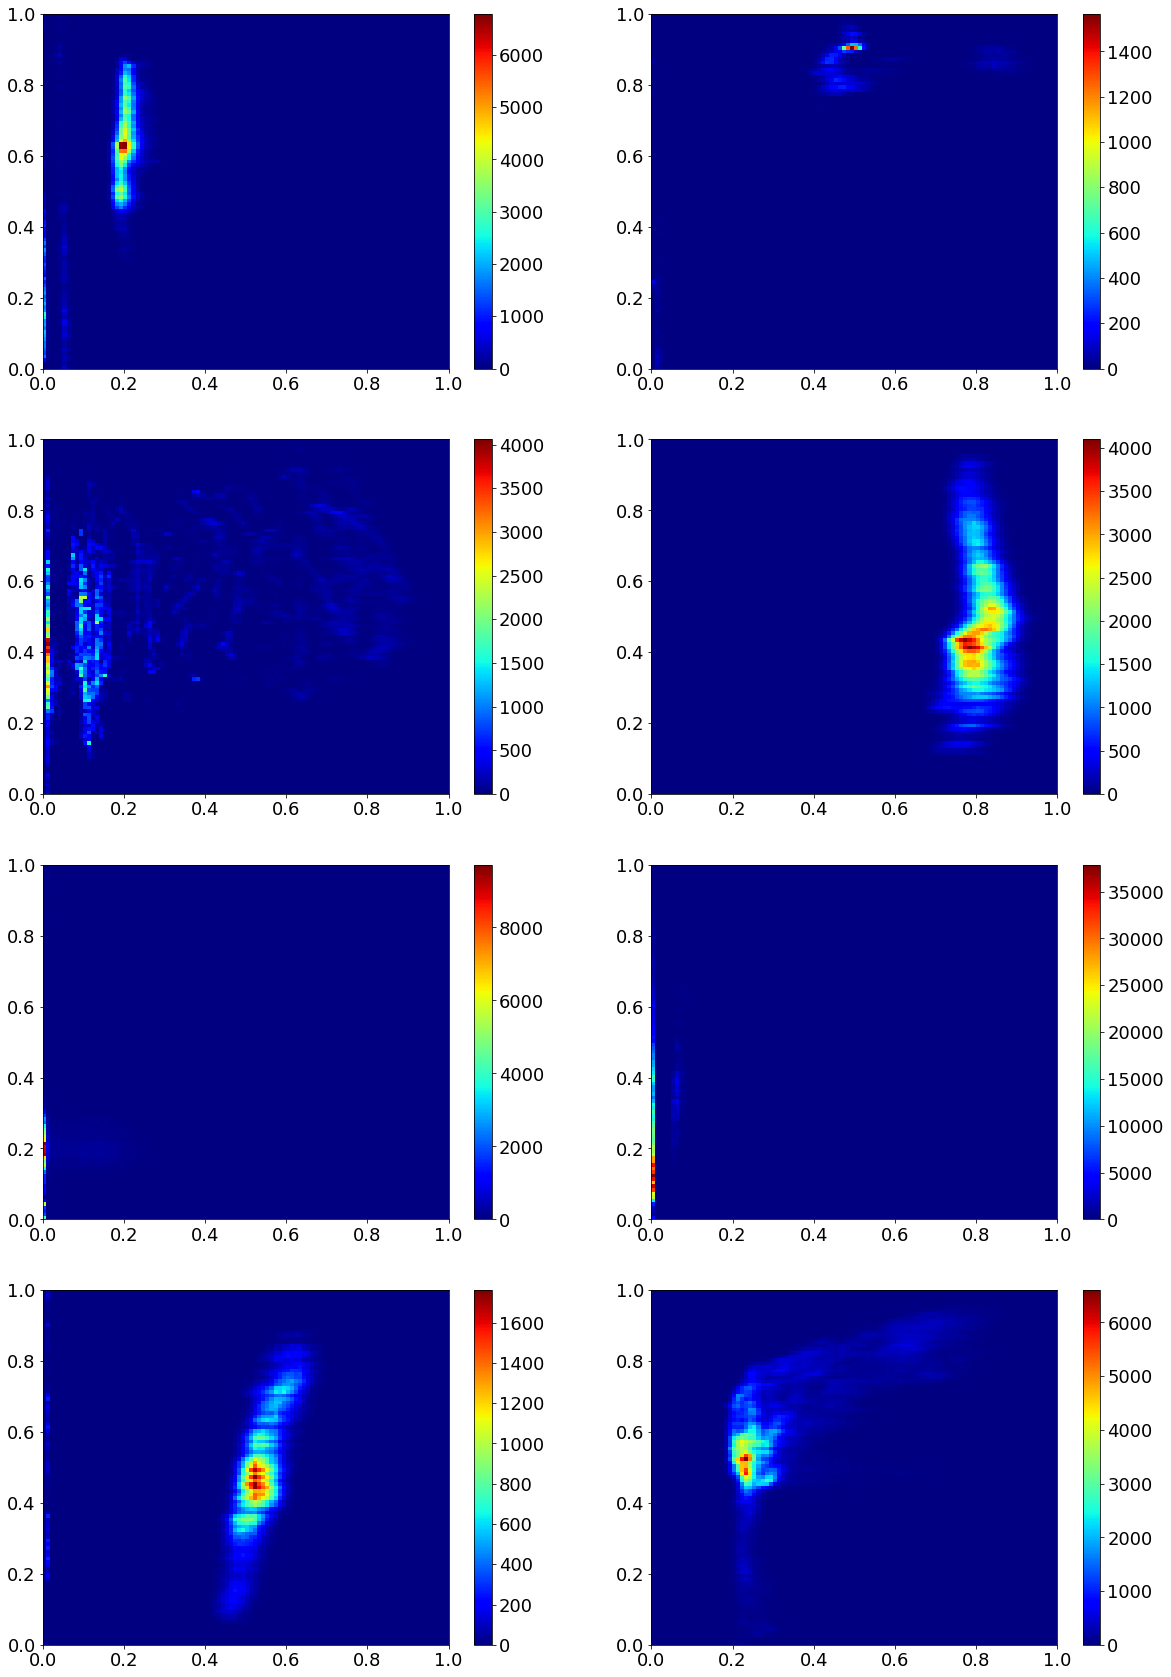

In [19]:
plt.figure(figsize=(20,30))
i = 1
for i in range(8):
    plt.subplot(4,2,i+1)
    scatter = dataframes[i].dropna()
    scatter_norm = normalize(scatter)
    plt.hist2d(scatter_norm.vel_rms_e, scatter_norm.object_temp, (100, 100), cmap=plt.cm.jet)
    plt.colorbar()
plt.show()

In [132]:
components = []
for dataframe in dataframes:
    components.append(normalize(dataframe[["vel_rms_e", "object_temp"]].dropna()).to_numpy())

In [139]:
dispersao = []
for component in components:
    a, b = np.ceil(10*np.std(component[:,0])), np.ceil(10*np.std(component[:,1]))
    dispersao.append(int(a+b)/2)

In [141]:
clusters = []
for component, cluster in zip(components_array, dispersao):
    clusters.append(KMeans(n_clusters=int(cluster), random_state=0).fit(component))

In [142]:
gmList = []
for component, cluster in zip(components_array, dispersao):
    gmList.append(GaussianMixture(n_components=int(cluster), random_state=0).fit(component))

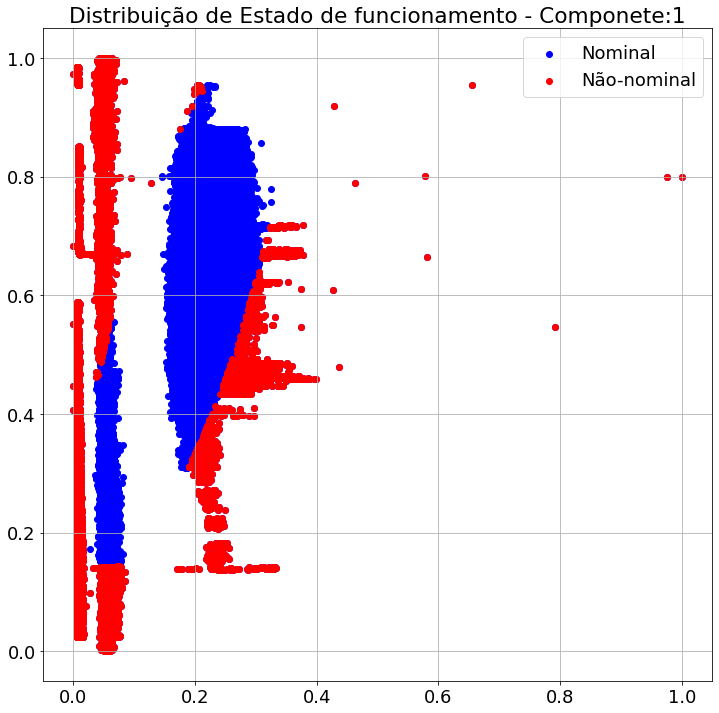

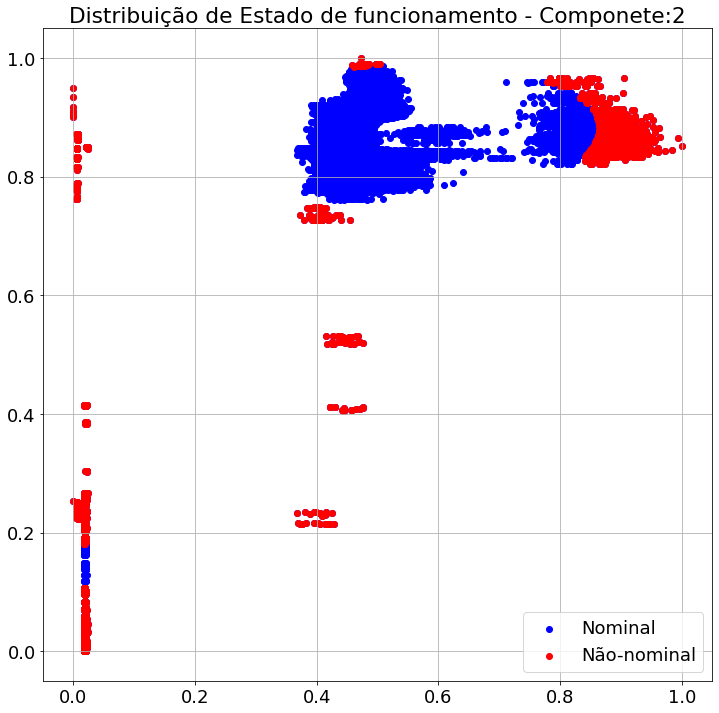

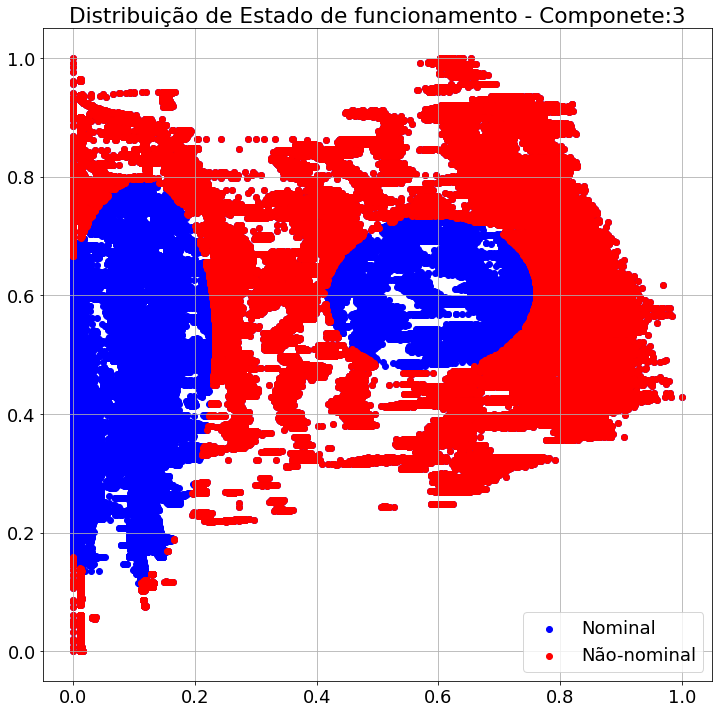

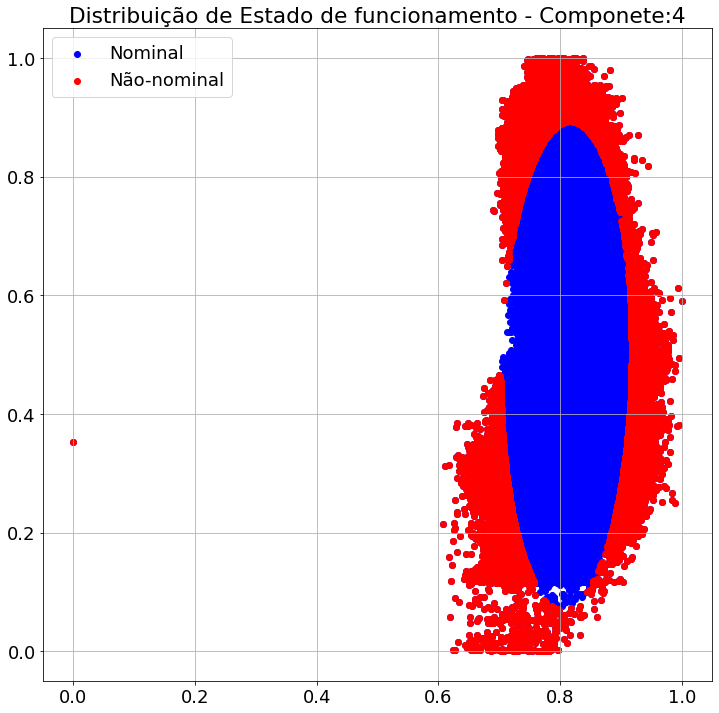

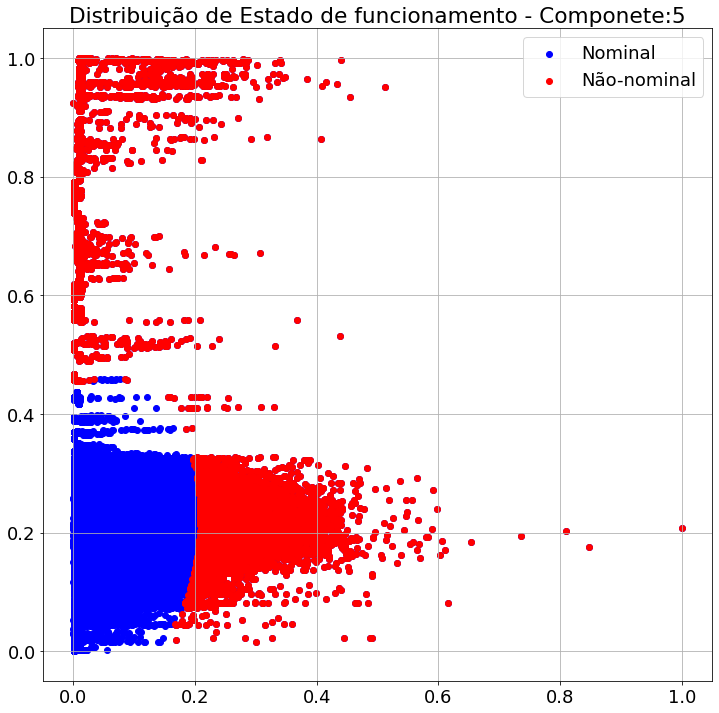

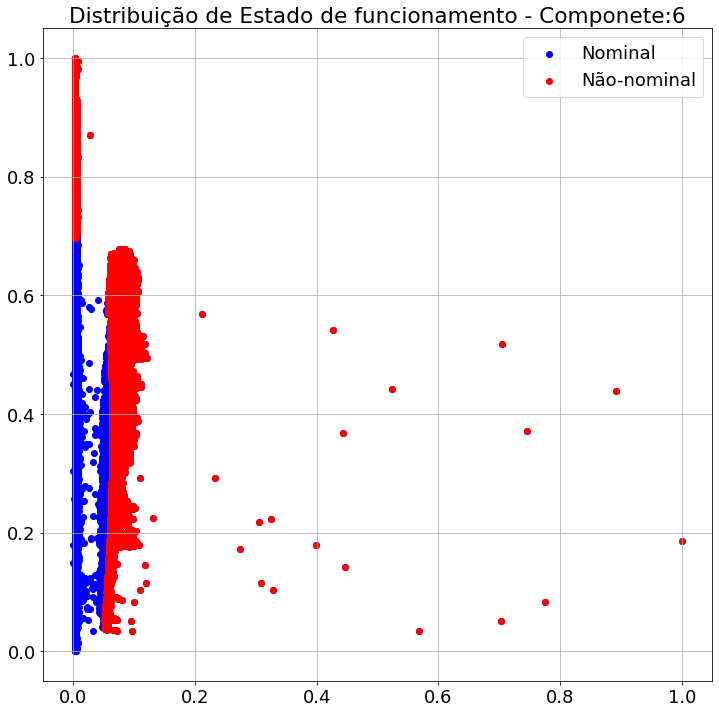

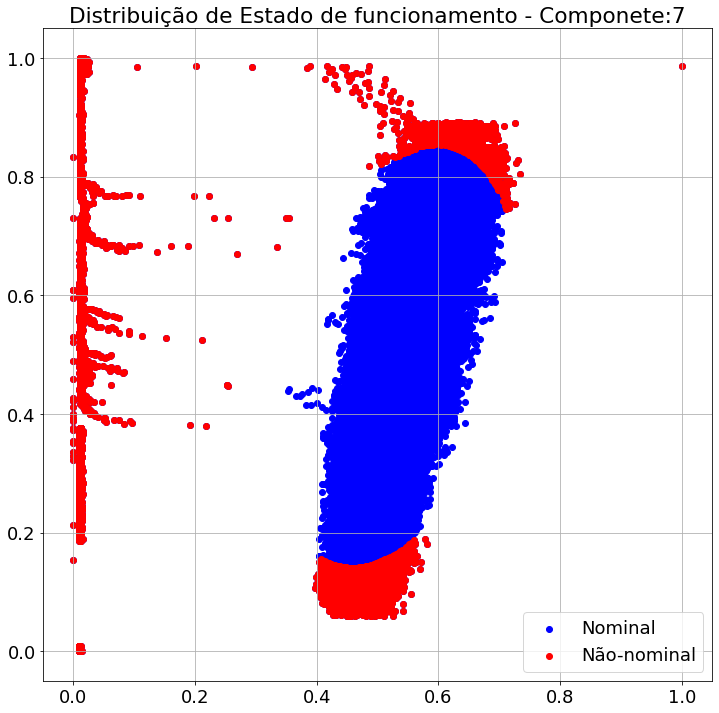

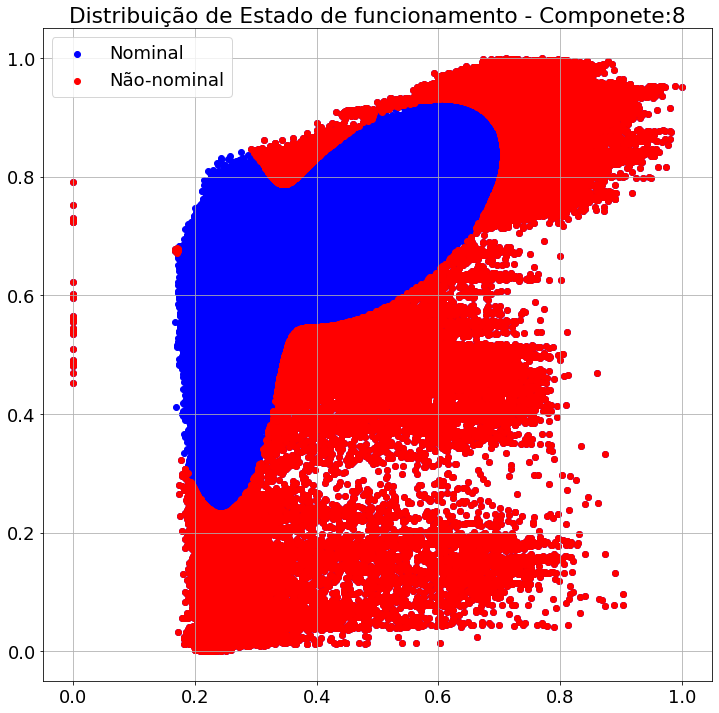

In [165]:
for j in range(8):
    
    component_test = j
    modelo = gmList[component_test].score_samples(components[component_test])

    falha = 0

    index = []

    for i in range(len(modelo)): 
        if modelo[i]<0:
            falha += 1
            index.append(components[component_test][i])
        
    plt.figure(figsize=(12,12))
    plt.scatter(components[component_test][:,0], components[component_test][:,1], color='blue', label='Nominal')
    plt.scatter(np.array(index)[:,0], np.array(index)[:,1], color='red', label='Não-nominal')
    plt.legend(loc='best')
    plt.title('Distribuição de Estado de Funcionamento - Componente:' + str(j+1))
    plt.grid(True)
    plt.show()